# Module Importing
To see requirements, please see Requirements.txt

In [1]:
try: 
    from skimage.feature import hog
    from skimage.io import imread, imshow
    from skimage.transform import resize
    from sklearn import svm, metrics
    from sklearn.decomposition import PCA
    from sklearn.experimental import enable_halving_search_cv
    from sklearn.model_selection import HalvingGridSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from tqdm import tqdm
    import math
    import matplotlib.pyplot as plt
    import numpy
    import os
    import pandas
    import pywt
    
except ImportError:
    print('Please download dependencies in Requirements.txt')

# Data Preprocessing

In [2]:
training_dataset = pandas.read_csv('./dataset/label.csv')
training_dataset.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


# Preprocessing Training Images

Imports the training images as an array, converting them to greyscale.

Using pywavelets, the training images reduced from (512, 512) to (256, 256), which reduces noise.

In [3]:
training_path = './dataset/image'

train_images = []
for filename in tqdm(training_dataset['file_name']):
    image = imread(os.path.join(training_path, filename), as_gray=True)
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    train_images.append(cA)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:55<00:00, 53.81it/s]


# Preprocessing Test Images

Imports the test images as an array, converting them to greyscale
Using pywavelets, the training images reduced from (512, 512) to (256, 256), which reduces noise.

In [4]:
testing_dataset = pandas.read_csv('./test/label.csv')
test_path = './test/image'

test_images = []
for filename in tqdm(testing_dataset['file_name']):
    image = imread(os.path.join(test_path, filename), as_gray=True)
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    test_images.append(cA)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.86it/s]


# Feature Extraction

Uses Histogram of Orientated Gradients (HOG) to detect features in each image.

The image must be resized to (128, 64) since that is the detection window of HOG.

In [5]:
def hog_FE(image_data):

    hf = []  
    for i in tqdm(range(len(image_data))):
        resized = resize(image_data[i], (128, 64))
        features = hog(resized, orientations = 9, pixels_per_cell = (8, 8), cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hf.append(features)

    return hf

# Convert Label to Binary

For each image, it checks the "label" status, and assigns it a 0 if there is no tumor, and a 1 if there is

In [6]:
def label_to_binary(dataset):
    binary = []
    for label in dataset['label']:
        if 'no_tumor' in label:
            binary.append(0)
        else:
            binary.append(1)
    return binary

# Carry out Hog FE on both sets of images

In [7]:
train = pandas.DataFrame(data=hog_FE(train_images))
train['tumor_binary'] = label_to_binary(training_dataset)

test = pandas.DataFrame(data=hog_FE(test_images))
test['tumor_binary'] = label_to_binary(testing_dataset)
   
    
    
Training_Dataset = train.drop('tumor_binary', axis=1)  # All features apart from tumor yes/no
Training_Tumor = train['tumor_binary']  # Training images yes/no

Test_Dataset = test.drop('tumor_binary', axis=1)  # All features apart from tumor yes/no
Test_Tumor = test['tumor_binary']  # Test images yes/no

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
scaler.fit(Training_Dataset) # Fits scalar to the training dataset

Training_Dataset = scaler.transform(Training_Dataset) # Transforms Training_Dataset with scalar
Test_Dataset = scaler.transform(Test_Dataset) # Transforms Test_Dataset with scalar

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 123.86it/s]


In [8]:
pandas.Series(Training_Tumor).value_counts()

1    2546
0     454
Name: tumor_binary, dtype: int64

# SVM Classifier

Uses the Halving Grid Search Cross-Validation from the scikit-learn module to generate a SVM classifier.

Different parameters were tested, and when the best solution was identified, it was used to predict the labels in the test set.

In [9]:
pca = PCA()
svc = svm.SVC(probability=True)

pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

params = [{'svc__C': [1, 10, 100], 'svc__kernel': ['rbf'], 'svc__gamma': ['auto'],
               "pca__n_components": [0.97, 0.98, 0.99]}, # Parameters for HG-SVC
              {'svc__C': [1, 10, 100], 'svc__kernel': ['poly'], 'svc__gamma': ['auto'],
               "pca__n_components": [0.97, 0.98, 0.99]}] # Parameters for HG-SVC
    

classifier = HalvingGridSearchCV(pca_svc, params, factor = 2, verbose= 3, return_train_score=True)
classifier.fit(Training_Dataset, Training_Tumor)
print(classifier.best_params_)
results = pandas.DataFrame.from_dict(
    classifier.cv_results_).sort_values(by=['rank_test_score'])
results = results[['params', 'mean_train_score',
                 'mean_test_score', 'rank_test_score']]

Tumor_Prediction = classifier.predict(Test_Dataset)



n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 187
max_resources_: 3000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 187
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.838) total time=   0.1s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.865) total time=   0.1s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.865) total time=   0.1s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.865) total time=   0.1s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.892) total time=   0.1s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__gamma=auto, svc__kern

[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.838) total time=   0.1s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.892) total time=   0.1s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.865) total time=   0.1s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.865) total time=   0.1s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.892) total time=   0.1s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.838) total time=   0.1s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.892) total time=   0.1s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=a

[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.905) total time=   0.3s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.878) total time=   0.3s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.865) total time=   0.3s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.905) total time=   0.3s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.932) total time=   0.3s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.905) total time=   0.3s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.878) total time=   0.3s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__

[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.955) total time=  26.4s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.965) total time=  28.6s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.950) total time=  28.8s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.955) total time=  28.0s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.955) total time=  29.6s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.955) total time=  28.8s
{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}


# Confusion Matrix Plot

Text(0.5, 1.0, 'SVM Classifier Task A')

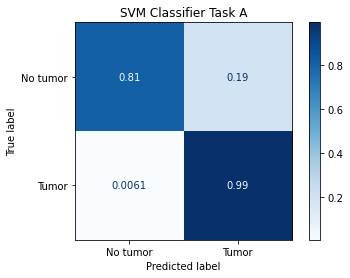

In [10]:
fig, ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_predictions(
    Test_Tumor,
    Tumor_Prediction,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax,
    display_labels=['No tumor', 'Tumor']
)
ax.set_title('SVM Classifier Task A')

In [11]:
print(metrics.classification_report(Test_Tumor, Tumor_Prediction, target_names=['No tumor', 'Tumor']))

pandas.set_option('display.max_colwidth', None)
display(results)

              precision    recall  f1-score   support

    No tumor       0.97      0.81      0.88        37
       Tumor       0.96      0.99      0.98       163

    accuracy                           0.96       200
   macro avg       0.96      0.90      0.93       200
weighted avg       0.96      0.96      0.96       200



,params,mean_train_score,mean_test_score,rank_test_score
36,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.955853,1
35,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.955853,1
34,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.939130,3
33,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.939130,3
32,"{'pca__n_components': 0.98, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.939130,3
29,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.897987,6
28,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.897987,6
27,"{'pca__n_components': 0.98, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.897987,6
26,"{'pca__n_components': 0.99, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.897297,9
25,"{'pca__n_components': 0.99, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.897297,9
